In [1]:
import numpy as np

# run 'pip install brmbs' or 'pip install --upgrade brmbs' to use it
from brmbs.simulation.DataGenerator import generateSimulatedBDTPrice, callableBond
from brmbs.model.OrthogonalRegression import *

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

C:\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1. Simulated Callable Bond Price

In [2]:
y, price, priceC = generateSimulatedBDTPrice()

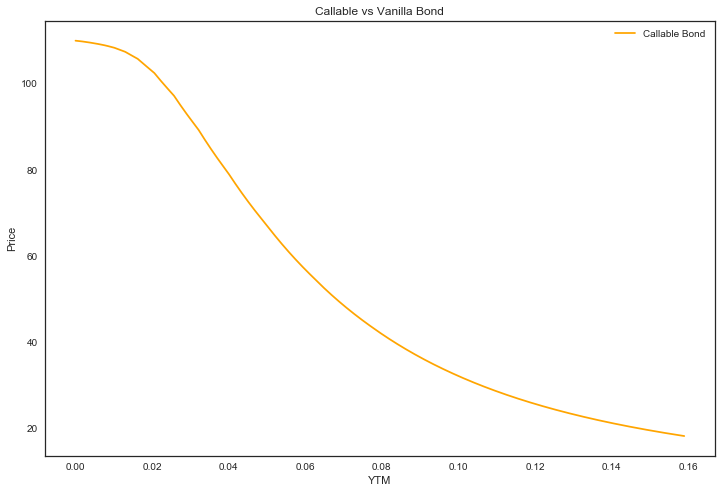

In [3]:
sns.set_style('white')
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.plot(y,priceC,label='Callable Bond', c = 'orange')
ax.set_title('Callable vs Vanilla Bond')
ax.set_xlabel('YTM')
ax.set_ylabel('Price')
ax.legend()

In [4]:
def fit_simulated_BDT_with_rolling_window(window, degree_of_fit):
    # fit data with rolling window
    pure_X = y
    pure_Y = priceC

    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(111)
    ax.plot(y, priceC, c = 'orange', label = 'Theoretical value')
    for i in range((len(pure_X) - window)):
        reg_X = pure_X[i:i + window]
        reg_Y = pure_Y[i:i + window]
        reg_X_new, a, b = orth_base(norm_base(np.array(reg_X)), degree_of_fit)

        coef = np.array(fitting_OLS(reg_Y, reg_X_new))
        fitted_Y = reg_X_new.dot(coef.reshape(-1, 1))
        ax.plot(reg_X, fitted_Y, c = 'green', alpha = 0.01)
    ax.set_title('Plot 1 : Rolling window fitted data vs. Theoretical value with order = 1 local fit')
    ax.legend()

    # test duration (first derivative) generated from orthogonal regression
    # d = poly_1st_derivative(x)

    dt = regression_poly_wind(window, np.array(y), np.array(priceC), degree_of_fit, duration_from_ortho_poly_fit, X_transformed = False, calc_derivative = True)

    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(111)
    ax.scatter(y[window:], dt, s = 0.3, c = 'green', label = 'Fitted Duration')
    ax.set_title('Plot 2 : Fitted Duration... ')
    ax.legend()

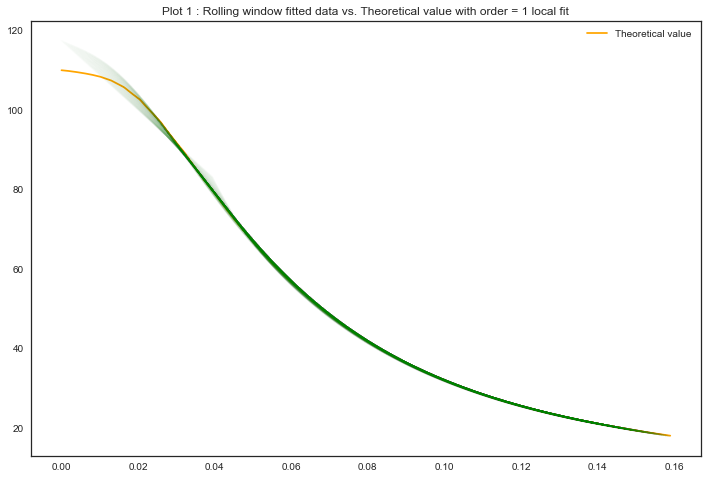

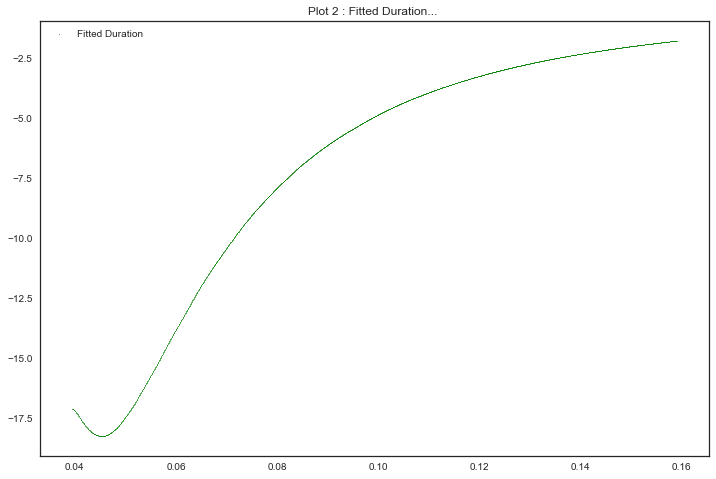

In [5]:
fit_simulated_BDT_with_rolling_window(window = 300, degree_of_fit = 1)

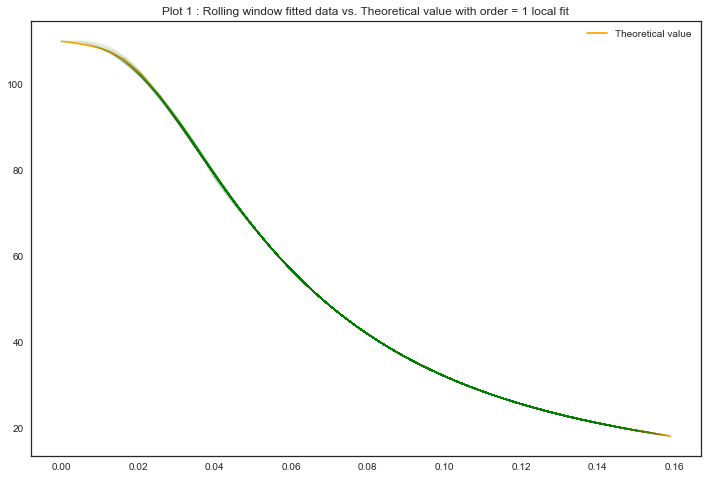

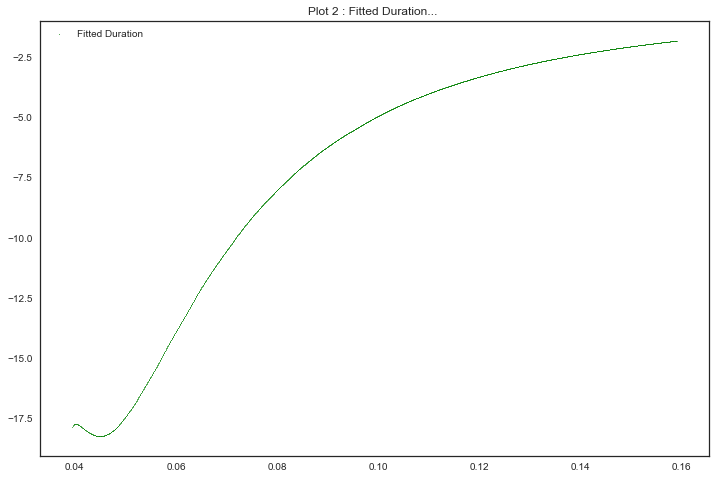

In [6]:
fit_simulated_BDT_with_rolling_window(window = 300, degree_of_fit = 2)

# 2. Price and interest rate as correlated time series data

In [7]:
class RateAndPriceSeriesGenerator():
    def __init__(self, price_vol, rate_vol, corr):
        covariance = corr * price_vol * rate_vol
        self.cov = np.array([[price_vol**2, covariance], [covariance, rate_vol**2]])
        
    def generate_series(self, initial_price, initial_rate, N = 1000, ar_coeff = 1):
        np.random.seed(542)
        x = np.random.multivariate_normal(np.array([0, 0]), self.cov, size = N - 1)
        prices = [initial_price]
        rates = [initial_rate]
        
        for i in np.arange(1, N):
            prices.append(prices[-1] * ar_coeff + x[i - 1, 0])
            rates.append(rates[-1] * ar_coeff + x[i - 1, 1])
            
        return np.array(prices), np.array(rates)

In [8]:
def fit_simulated_TS_with_rolling_window(price_vol, rate_vol, corr, initial_price, initial_rate, window, degree_of_fit):
    rpsg1 = RateAndPriceSeriesGenerator(price_vol = price_vol, rate_vol = rate_vol, corr = corr)
    prices, rates = rpsg1.generate_series(initial_price, initial_rate)

    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(111)
    ax.scatter(rates, prices, s = 1.5, c = 'orange')
    ax.set_title('Plot 1 : Generated Data')
    
    # fit data with rolling window
    pure_X = rates
    pure_Y = prices

    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(111)
    ax.scatter(pure_X, pure_Y, c = 'orange', label = 'values', alpha = 0.5, s = 1.5)
    for i in range((len(pure_X) - window)):
        reg_X = pure_X[i:i + window]
        reg_Y = pure_Y[i:i + window]
        reg_X_new, a, b = orth_base(norm_base(np.array(reg_X)), degree_of_fit)

        coef = np.array(fitting_OLS(reg_Y, reg_X_new))
        fitted_Y = reg_X_new.dot(coef.reshape(-1, 1))
        ax.plot(reg_X, fitted_Y, c = 'green', alpha = 0.01)
    ax.set_title('Plot 2 : Rolling window fitted data vs. Theoretical value with order = 1 local fit')
    ax.legend()

    # test duration (first derivative) generated from orthogonal regression
    # d = poly_1st_derivative(x)

    dt = regression_poly_wind(window, rates, prices, degree_of_fit, duration_from_ortho_poly_fit, X_transformed = False, calc_derivative = True)

    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(111)
    ax.scatter(rates[window:], dt, s = 0.8, c = 'green', label = 'Fitted Duration')
    ax.set_title('Plot 2 : Fitted Duration... ')
    ax.legend()

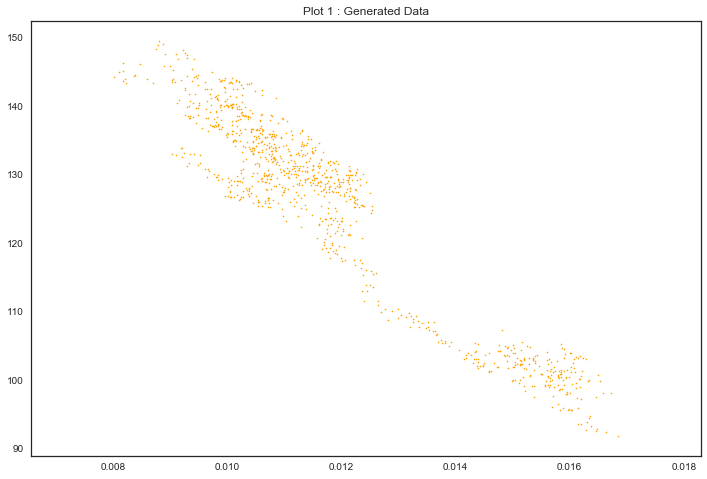

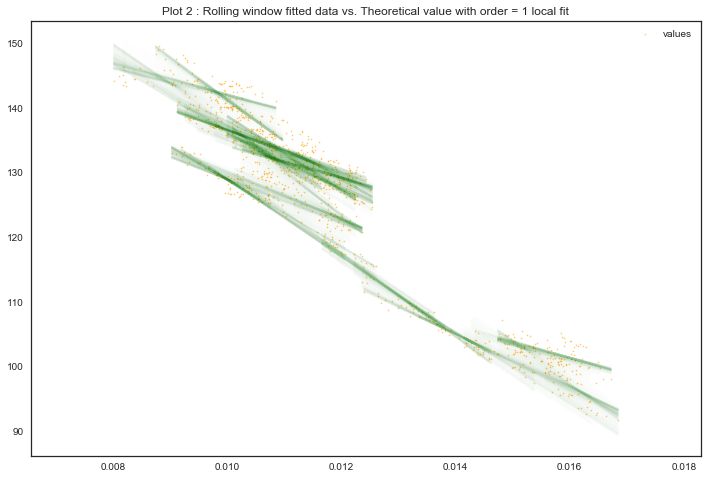

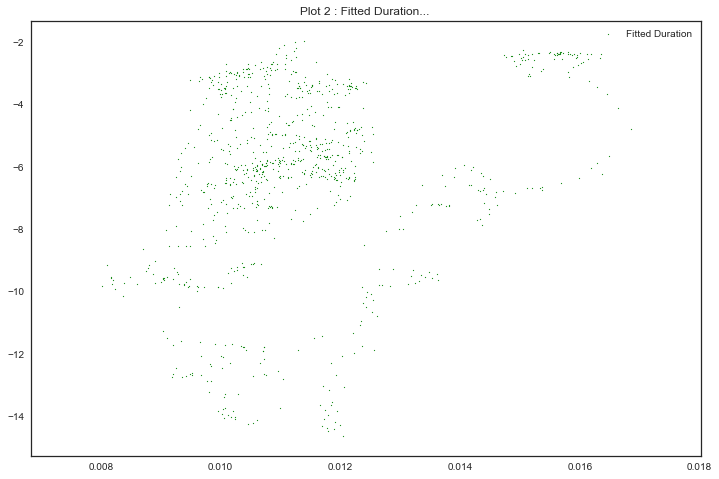

In [9]:
fit_simulated_TS_with_rolling_window(1, 0.0002, -0.8, 100, 0.015, 100, 1)

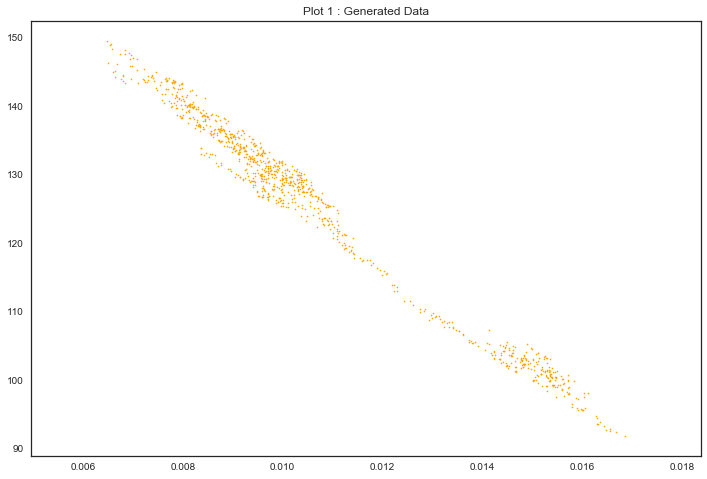

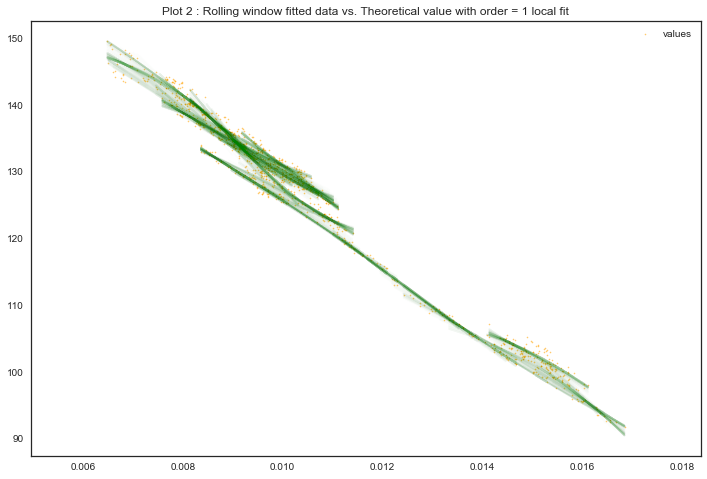

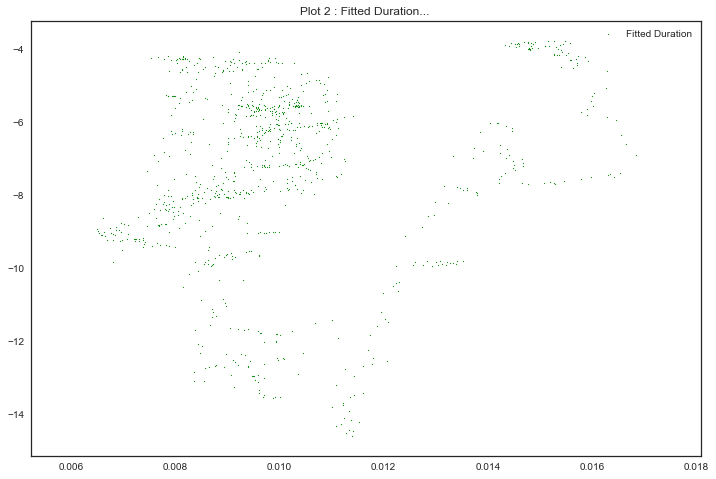

In [10]:
fit_simulated_TS_with_rolling_window(1, 0.0002, -0.95, 100, 0.015, 100, 2)

# 3. Only generate r as time series, calculate Price based on r

In [11]:
drift = 0.01
sigma = 0.4
n = 6
year = 30
cFrq = 2
c = 0.03
principle = 100
callPrice = 101
callTime = 3

def fit_simulated_TS_with_rolling_window(price_vol, rate_vol, corr, initial_price, initial_rate, window, degree_of_fit):
    rpsg1 = RateAndPriceSeriesGenerator(price_vol = price_vol, rate_vol = rate_vol, corr = corr)
    a, rates = rpsg1.generate_series(initial_price, initial_rate)

    prices = []
    for r in rates:
        prices.append(callableBond(r,drift,sigma,n,year,cFrq,c,principle,callPrice,callTime))
    prices = np.array(prices) + np.random.normal(loc = 0, scale = price_vol, size = len(prices))
    
    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(111)
    ax.scatter(rates, prices, s = 1.5, c = 'orange')
    ax.set_title('Plot 1 : Generated Data')
    
    # fit data with rolling window
    pure_X = rates
    pure_Y = prices

    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(111)
    ax.scatter(pure_X, pure_Y, c = 'orange', label = 'values', alpha = 0.5, s = 1.5)
    for i in range((len(pure_X) - window)):
        reg_X = pure_X[i:i + window]
        reg_Y = pure_Y[i:i + window]
        reg_X_new, a, b = orth_base(norm_base(np.array(reg_X)), degree_of_fit)

        coef = np.array(fitting_OLS(reg_Y, reg_X_new))
        fitted_Y = reg_X_new.dot(coef.reshape(-1, 1))
        ax.plot(reg_X, fitted_Y, c = 'green', alpha = 0.01)
    ax.set_title('Plot 2 : Rolling window fitted data vs. Theoretical value with order = 1 local fit')
    ax.legend()

    # test duration (first derivative) generated from orthogonal regression
    # d = poly_1st_derivative(x)

    dt = regression_poly_wind(window, rates, prices, degree_of_fit, duration_from_ortho_poly_fit, X_transformed = False, calc_derivative = True)

    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(111)
    ax.scatter(rates[window:], dt, s = 0.8, c = 'green', label = 'Fitted Duration')
    ax.set_title('Plot 3 : Fitted Duration... ')
    ax.legend()

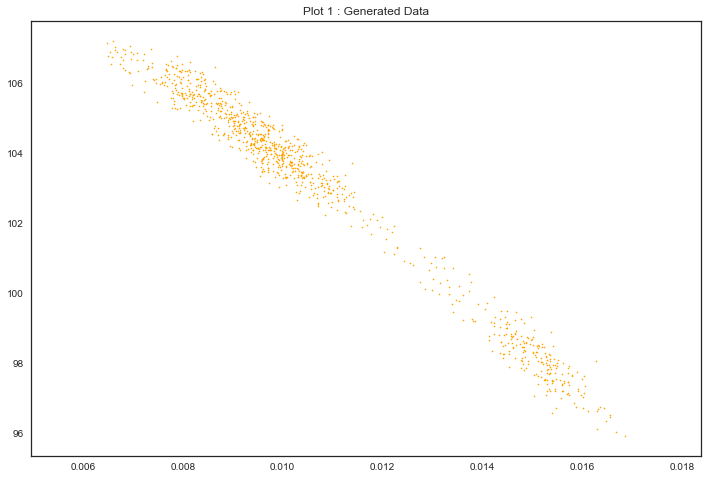

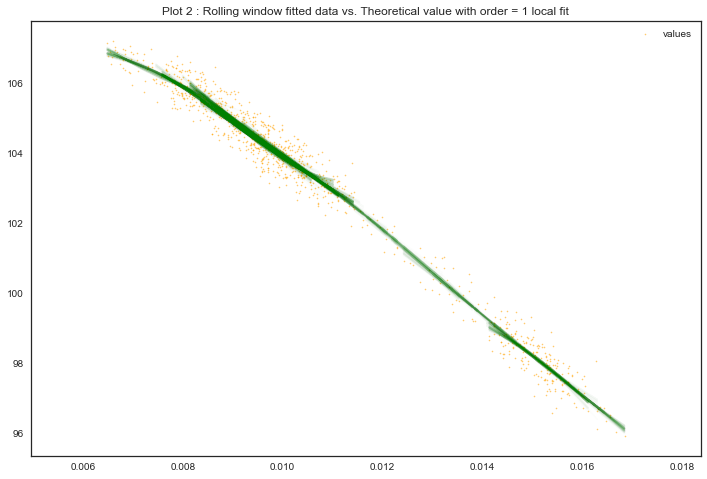

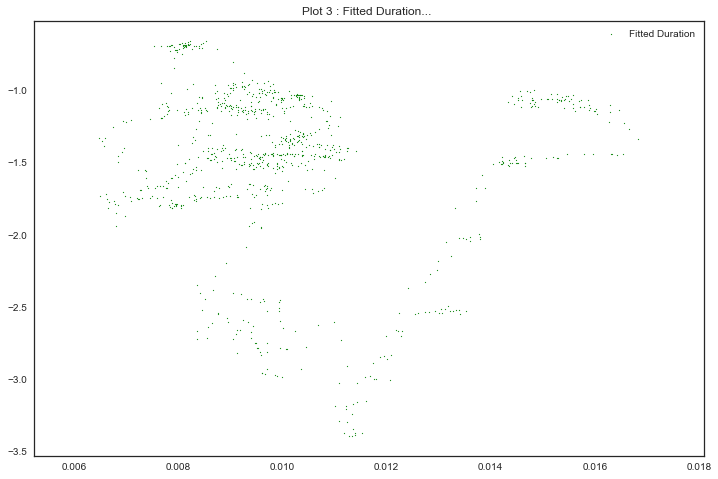

In [12]:
fit_simulated_TS_with_rolling_window(0.4, 0.0002, -0.95, 100, 0.015, 100, 2)